## Attempt to reproduce BlackJack in the text

It seems there are two region that remain fuzzy for usable_ace and no usable_ace respectively (I increased the loop to 10x for those regions already). It might take a long time for those regions to converge. But overall it looks correct.

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import collections
import pandas as pd
import typing
from truth.truth import AssertThat
%matplotlib inline
rng = np.random.default_rng()

In [134]:
CARDS = list(range(1, 10)) + [10] * 4

class Hand:
    def __init__(self, usable_ace, hand_sum):
        self.usable_ace = usable_ace
        self.sum = hand_sum

    def hit(self, card):
        self.sum += card
        if card == 1 and self.sum + 10 <= 21:
                self.sum += 10
                self.usable_ace = True
        
        if self.sum > 21 and self.usable_ace:
            self.sum -= 10
            self.usable_ace = False
        return self
    
    def usable_ace(self):
        return self.usable_ace

In [135]:
# 2 aces -> 11 + 1 points 
test_hand = Hand(True, 12)
# hit 10
test_hand.hit(10)
assert test_hand.sum == 12

# 2 aces
test_hand = Hand(False, 12)
test_hand.hit(10)
assert test_hand.sum == 22


In [266]:
GameState = typing.NamedTuple("GameState", [("player_sum", int), ("dealer_showing", int), ("usable_ace", int)])

class BlackJack:
    def initialize(self, player_sum, player_usable_ace, dealer_showing):
        self.player_hand = Hand(player_usable_ace and player_sum >= 11, player_sum)
        self.dealer_hand = Hand(dealer_showing == 1, dealer_showing if dealer_showing != 1 else 11)
        self.dealer_showing = dealer_showing
        self.game_ended = 0
        
    # dealer only has the showing card in initialize, keep drawing until dealer has over 12 points
    def dealer_card_fill(self):
        while self.dealer_hand.sum < 12:
            self.dealer_hand.hit(self.draw())
        
    def draw(self):
        return rng.choice(CARDS, replace=True)
    
    def get_observation(self):
        return (GameState(player_sum=self.player_hand.sum,
                          dealer_showing=self.dealer_showing,
                          usable_ace=int(self.player_hand.usable_ace)), self.game_ended)
    
    def apply_action(self, hit):
        if hit:
            self.player_hand.hit(self.draw())
        
        dealer_hit = False
        if self.dealer_hand.sum < 17:
            dealer_hit = True
            self.dealer_hand.hit(self.draw())
        
        if (not dealer_hit and not hit) or (self.player_hand.sum >= 21 or self.dealer_hand.sum >= 21):
            reward = self.calc_result()
            self.game_ended = 1
            return reward
        
        return 0
    
    def calc_result(self):
        if self.player_hand.sum > 21:
            if self.dealer_hand.sum > 21:
                return 0
            else:
                return -1
        elif self.player_hand.sum == 21:
            if self.dealer_hand.sum == 21:
                return 0
            else:
                return 1
        # player sum < 21
        else:
            if self.dealer_hand.sum > 21:
                return 1
            else:
                if self.dealer_hand.sum > self.player_hand.sum:
                    return -1
                elif self.dealer_hand.sum == self.player_hand.sum:
                    return 0
                else:
                    return 1
        
        

In [316]:
def stub_draw(test_deck):
    return lambda: test_deck.pop(0)

# Test 1: Player hand: A 10 ,   Dealer hand: 5 9
bj = BlackJack()
bj.initialize(21, True, 5)
bj.draw = stub_draw([9, 7, 3])
bj.dealer_card_fill()
AssertThat(bj.get_observation()).IsEqualTo((GameState(21, 5, True), False))
# Player doesn't hit, dealer < 17 should hit and get 7
reward = bj.apply_action(False)
AssertThat(bj.get_observation()).IsEqualTo((GameState(21, 5, True), True))
assert reward == 0

# Test 2
bj = BlackJack()
bj.initialize(21, True, 5)
bj.player_hand.sum,  bj.dealer_hand.sum = 20, 21
assert bj.calc_result() == -1
bj.player_hand.sum,  bj.dealer_hand.sum = 23, 21
assert bj.calc_result() == -1
bj.player_hand.sum,  bj.dealer_hand.sum = 23, 15
assert bj.calc_result() == -1
bj.player_hand.sum,  bj.dealer_hand.sum = 1, 2
assert bj.calc_result() == -1
bj.player_hand.sum,  bj.dealer_hand.sum = 2, 1
assert bj.calc_result() == 1
bj.player_hand.sum,  bj.dealer_hand.sum = 15, 23
assert bj.calc_result() == 1
bj.player_hand.sum,  bj.dealer_hand.sum = 21, 15
assert bj.calc_result() == 1
bj.player_hand.sum,  bj.dealer_hand.sum = 21, 23
assert bj.calc_result() == 1
bj.player_hand.sum,  bj.dealer_hand.sum = 22, 22
assert bj.calc_result() == 0
bj.player_hand.sum,  bj.dealer_hand.sum = 15, 15
assert bj.calc_result() == 0
bj.player_hand.sum,  bj.dealer_hand.sum = 21, 21
assert bj.calc_result() == 0

# Test 3
# Player hand: A, 7,  Dealer hand: A, 8
bj.initialize(18, True, 1)
assert bj.dealer_hand.usable_ace == 1
bj.draw = stub_draw([8, 7, 5])
bj.dealer_card_fill()
AssertThat(bj.get_observation()).IsEqualTo((GameState(18, 1, True), False))
# Player should hit,  get 11 + 7 + 7 = 25 (use ace) -> 15 ,  Dealer doesn't hit
reward = bj.apply_action(True)
assert reward == 0
AssertThat(bj.get_observation()).IsEqualTo((GameState(15, 1, False), False))
assert bj.calc_result() == -1  # will lose at this point 15 < 19
# Player hit to get to 20,  Dealer won't hit , staying at 19
reward = bj.apply_action(True)
assert reward == 0
AssertThat(bj.get_observation()).IsEqualTo((GameState(20, 1, False), False))
reward = bj.apply_action(False)
assert reward == 1
AssertThat(bj.get_observation()).IsEqualTo((GameState(20, 1, False), True))

# Test 4
# Player hand: A, 7,  Dealer hand: A, 2
bj.initialize(18, True, 1)
bj.draw = stub_draw([2, 7, 5])
bj.dealer_card_fill()
reward = bj.apply_action(True)
assert reward == 0
AssertThat(bj.get_observation()).IsEqualTo((GameState(15, 1, False), False))
assert bj.dealer_hand.usable_ace == True
assert bj.dealer_hand.sum == 18

# Test 5
# Player hand: A, 7,  Dealer hand: A, 2
bj.initialize(18, True, 1)
bj.draw = stub_draw([2, 7, 10])
bj.dealer_card_fill()
reward = bj.apply_action(True)
assert reward == 0
AssertThat(bj.get_observation()).IsEqualTo((GameState(15, 1, False), False))
assert bj.dealer_hand.usable_ace == False
assert bj.dealer_hand.sum == 13

In [307]:
### Monte Carlo with Exploring start and every visit update
def mces_every_visit(env, epochs, psum_range=range(12, 22), dcard_range=range(1, 11)):
    err_bound_per_iter = []
    N = collections.defaultdict(int) # counts the # of times (s,a) is visited.
    q = np.zeros((22, 12, 2, 2)) # player_sum, dealer_showing, usable_ace, hit/stick
    pi = np.zeros((22, 12, 2), dtype=np.uint) # (player_sum, dealer_showing, ace_usable) -> hit/stick
    
    for _ in tqdm(range(epochs)):
        update_err_bound = -1
        for (player_sum, usable_ace, dealer_showing, init_action) in itertools.product(
                psum_range, [0, 1], dcard_range, [0, 1]):

            repeat = 1
            # run more times in region with more uncertainty
            if usable_ace == 0 and player_sum >=12 and player_sum <= 16 and dealer_showing >= 2 and dealer_showing <= 6:
                repeat = 10
            elif usable_ace == 1 and (player_sum == 18 or player_sum == 17):
                repeat = 10
            for _ in range(repeat):
                # Generate episode based on starting states
                # For each episode
                ep = []
                env.initialize(player_sum=player_sum, player_usable_ace=usable_ace, dealer_showing=dealer_showing)
                env.dealer_card_fill()
                s, game_ended = env.get_observation()

                r = env.apply_action(init_action)
                ep.append((s, init_action, r))

                # start following policy after init_action is performed.
                s, game_ended = env.get_observation()
                while not game_ended:
                    a = pi[s.player_sum, s.dealer_showing, s.usable_ace]
                    r = env.apply_action(a)
                    ep.append((s, a, r))
                    s, game_ended = env.get_observation()

                # Update q(s,a)
                g = 0.0
                while len(ep) > 0:
                    s, a, r = ep.pop()
                    g += r 
                    N[(s,a)] += 1
                    gradient = (g - q[s.player_sum, s.dealer_showing, s.usable_ace, a])/ N[(s,a)]
                    q[s.player_sum, s.dealer_showing, s.usable_ace, a] += gradient #  q = q + 1/(n+1) (return - q)
                    pi[s.player_sum, s.dealer_showing, s.usable_ace] = np.argmax(q[s.player_sum, s.dealer_showing, s.usable_ace, :])

                    # logging
                    update_err_bound = max(abs(gradient), update_err_bound)
                
        err_bound_per_iter.append(update_err_bound)
        
    return (q, pi, err_bound_per_iter)


In [308]:
env = BlackJack()
q, pi, errs = mces_every_visit(env, 2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:03<00:00, 10.91it/s]


Text(0.5, 0, 'Epoch')

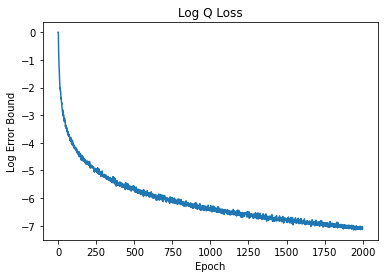

In [309]:
plt.plot(np.log(errs))
plt.title("Log Q Loss")
plt.ylabel("Log Error Bound")
plt.xlabel("Epoch")

In [310]:
def plot_policy(policy_matrix, ax, title):
    ax.matshow(policy_matrix)
    ax.invert_yaxis()
    ax.xaxis.set_ticks_position("bottom")
    ax.set_xticks(range(1,11))
    ax.set_yticks(range(12,22))
    ax.set_xlim((1,10))
    ax.set_ylim((12,21))
    ax.set_xlabel("Revealed Dealer's Card")
    ax.set_ylabel("Player Sum")
    ax.set_title(title)

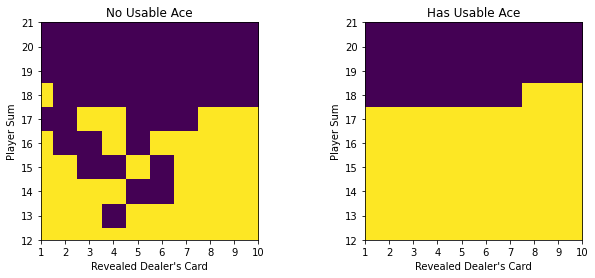

In [311]:
ax = plt.subplot(1, 2, 1)
plot_policy(pi[:, :, 0], ax, "No Usable Ace")
plt.subplots_adjust(right=1.5)
ax = plt.subplot(1, 2, 2)
plot_policy(pi[:, :, 1], ax, "Has Usable Ace")

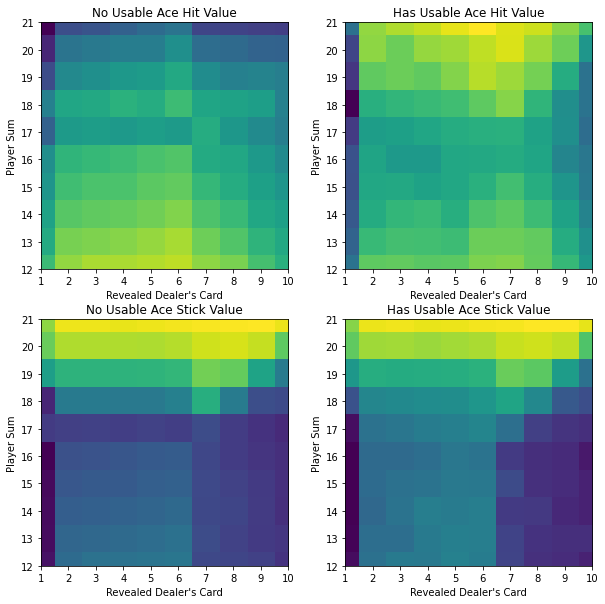

In [312]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(2, 2, 1)
plot_policy(q[:, :, 0, 1], ax, "No Usable Ace Hit Value")
ax = f.add_subplot(2, 2, 2)
plot_policy(q[:, :, 1, 1], ax, "Has Usable Ace Hit Value")
ax = f.add_subplot(2, 2, 3)
plot_policy(q[:, :, 0, 0], ax, "No Usable Ace Stick Value")
ax = f.add_subplot(2, 2, 4)
plot_policy(q[:, :, 1, 0], ax, "Has Usable Ace Stick Value")